# Fine-Tuning BERT with PyTorch

Run on Google Colab

Thanks to Chris McCormick and Nick Ryan

https://www.youtube.com/watch?v=x66kkDnbzi4&t=27s

## Setup

Google Colab offers free GPUs and TPUs. A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### Installing the Hugging Face Library

Install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give you a pytorch interface for working with BERT.

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained transformer models, the library also includes pre-built modifications of these models suited to your specific task. For example, in this tutorial we will use `BertForSequenceClassification`.

In [3]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 12.5 MB/s 
     |████████████████████████████████| 596 kB 49.5 MB/s 
     |████████████████████████████████| 895 kB 52.9 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Load own Data Set

In [4]:
import pandas as pd

In [5]:
# Upload the train file from your local drive, must be in chrome, not firefox
from google.colab import files
uploaded = files.upload()

Saving GermEval21_TrainData.csv to GermEval21_TrainData.csv


In [6]:
df = pd.read_csv("GermEval21_TrainData.csv")
df.head()

,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,1,Ziemlich traurig diese Kommentare zu lesen. Ih...,0,0,0
1,2,"Sag ich doch, wir befeuern den Klimawandel. Ra...",0,1,1
2,3,"Schublade auf, Schublade zu. Zu mehr Denkleist...",1,0,0
3,4,Dummerweise haben wir in der EU und in der USA...,0,0,1
4,5,"""So lange Gewinnmaximierung Vorrang hat, wird ...",0,0,0


In [7]:
df.shape

(3244, 5)

In [8]:
df.dropna(inplace=True)

In [9]:
len(df)

3244

In [10]:
df.Sub1_Toxic.value_counts()

0    2122
1    1122
Name: Sub1_Toxic, dtype: int64

In [11]:
# Get the lists of messages (sentences) and their labels.
sentences = df.comment_text.values
labels = df.Sub1_Toxic.values

In [12]:
print(sentences[1]) #second sentence
labels[1] #first label

Sag ich doch, wir befeuern den Klimawandel. Raucher können ihr Lebensende meiner Meinung nach auch gerne befeuern, nur hab ich daran kein Interesse.


0

### BERT Tokenizer

In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased', do_lower_case=True) 
#https://huggingface.co/bert-base-german-cased

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [14]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Ziemlich traurig diese Kommentare zu lesen. Ihr könnt euch zwar belügen, dass es den vom Menschen gemachten Klimawandel nicht gibt, nur kann man die Natur nicht belügen. Wie viele Menschen müssen denn noch auf Grund des Klimawandels ihre Lebensgrundlage verlieren oder gar Sterben, bis ihr den ernst der Lage erkannt habt?
Tokenized:  ['ziemlich', 'traur', '##ig', 'diese', 'komment', '##are', 'zu', 'lesen', '.', 'ihr', 'kon', '##nt', 'euch', 'zwar', 'bel', '##ugen', ',', 'dass', 'es', 'den', 'vom', 'menschen', 'gemachten', 'kl', '##ima', '##wandel', 'nicht', 'gibt', ',', 'nur', 'kann', 'man', 'die', 'natur', 'nicht', 'bel', '##ugen', '.', 'wie', 'viele', 'menschen', 'muss', '##en', 'denn', 'noch', 'auf', 'grund', 'des', 'kl', '##ima', '##wandel', '##s', 'ihre', 'lebens', '##grundlage', 'verlieren', 'oder', 'gar', 'sterben', ',', 'bis', 'ihr', 'den', 'ernst', 'der', 'lag', '##e', 'erkannt', 'hab', '##t', '?']
Token IDs:  [9431, 17179, 80, 620, 12827, 2079, 81, 9665, 26914, 254

### Required Formatting

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (2784 > 512). Running this sequence through the model will result in indexing errors


Original:  Ziemlich traurig diese Kommentare zu lesen. Ihr könnt euch zwar belügen, dass es den vom Menschen gemachten Klimawandel nicht gibt, nur kann man die Natur nicht belügen. Wie viele Menschen müssen denn noch auf Grund des Klimawandels ihre Lebensgrundlage verlieren oder gar Sterben, bis ihr den ernst der Lage erkannt habt?
Token IDs: [3, 9431, 17179, 80, 620, 12827, 2079, 81, 9665, 26914, 254, 494, 4053, 21529, 1616, 1519, 6054, 26918, 221, 229, 86, 275, 22311, 8445, 714, 3988, 16922, 149, 893, 26918, 356, 479, 478, 30, 8660, 149, 1519, 6054, 26914, 246, 1480, 22311, 1080, 7, 1803, 357, 115, 2044, 91, 714, 3988, 16922, 26902, 682, 9251, 6901, 11182, 309, 2523, 13781, 26918, 255, 254, 86, 5744, 21, 3227, 26897, 10135, 19009, 26901, 26972, 4]


Pad and truncate our sequences so that they all have the same length, `MAX_LEN`.

In [16]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  3059


In [17]:
import statistics
print('Mean sentence length: ', statistics.mean([len(sen) for sen in input_ids]))

Mean sentence length:  51.372071516646116


Given that, let's choose MAX_LEN = 64 and apply the padding.

In [18]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "[PAD]", ID: 0

Done.


The **attention mask** simply makes it explicit which tokens are actual words versus which are padding. 

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token.

In [19]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

#### Training & Validation Split

Divide up our training set to use 90% for training and 10% for validation.

In [20]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

#### Converting to PyTorch Data Types

In [21]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


### Train Classification Model



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-german-cased", # deepset ai
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

### Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32  (We chose 32 when creating our DataLoaders).
- Learning rate (Adam): 5e-5, 3e-5, 2e-5  (We'll use 2e-5).
- Number of epochs: 2, 3, 4  (We'll use 4).

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [25]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [26]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

### Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

Define a helper function for calculating accuracy.

In [27]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [28]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [29]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     92.    Elapsed: 0:00:28.
  Batch    80  of     92.    Elapsed: 0:00:55.

  Average training loss: 0.63
  Training epoch took: 0:01:03

Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     92.    Elapsed: 0:00:28.
  Batch    80  of     92.    Elapsed: 0:00:56.

  Average training loss: 0.51
  Training epoch took: 0:01:04

Running Validation...
  Accuracy: 0.74
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     92.    Elapsed: 0:00:28.
  Batch    80  of     92.    Elapsed: 0:00:56.

  Average training loss: 0.37
  Training epoch took: 0:01:04

Running Validation...
  Accuracy: 0.75
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     92.    Elapsed: 0:00:28.
  Batch    80  of     92.    Elapsed: 0:00:56.

  Average training loss: 0.26
  Training epoch took: 0:01:04

Ru

Let's take a look at our training loss over all batches:

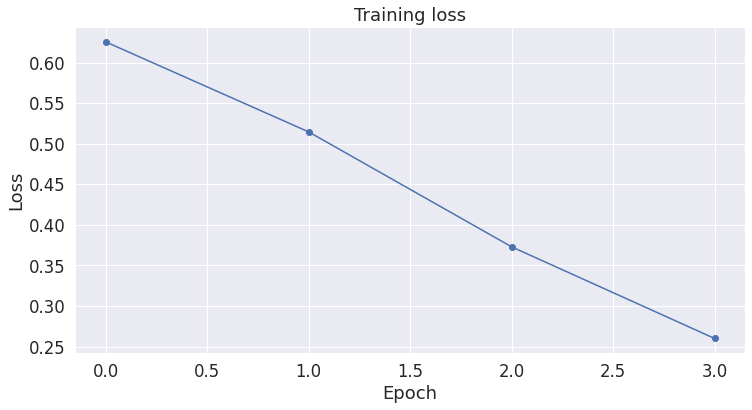

In [30]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Performance On Test Set

In [31]:
# Upload the train file from your local drive, must be in chrome, not firefox
from google.colab import files
uploaded = files.upload()

Saving GermEval21_TestData.csv to GermEval21_TestData.csv


In [32]:
#import pandas as pd

# Load the dataset into a pandas dataframe.
df_haf = pd.read_csv("GermEval21_TestData.csv")
len(df_haf)

944

In [33]:
df_haf.head()

,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...,1,1,0
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die...",0,1,1
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...,0,1,1
3,3248,"Als jemand, der im real existierenden Sozialis...",1,0,0
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...,1,0,0


In [34]:
df_haf.dropna(inplace=True)

In [35]:
df_haf.Sub1_Toxic.value_counts()

0    594
1    350
Name: Sub1_Toxic, dtype: int64

In [36]:
# Report the number of comments.
print('Number of test comments: {:,}\n'.format(df_haf.shape[0]))

# Create sentence and label lists
sentences = df_haf.comment_text.values
labels = df_haf.Sub1_Toxic.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 944



### Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [37]:
# Prediction on test set

print('Predicting labels for {:,} test comments...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 944 test comments...
    DONE.


In [65]:
predictions_list=[]
for i in predictions:
    for e in i:
    pred_labels_i = np.argmax(e)
    #print(e, pred_labels_i)
    predictions_list.append(pred_labels_i)

In [60]:
len(predictions_list)

944

In [66]:
df_haf['Predictions_bert'] = predictions_list
df_haf.head()

,comment_id,comment_text,Sub1_Toxic,Sub2_Engaging,Sub3_FactClaiming,Predictions_bert
0,3245,@USER Sie würden wahrscheinlich auch einen Kri...,1,1,0,1
1,3246,"@USER , ich glaube,Sie verkrnnen gründlich die...",0,1,1,0
2,3247,@USER: Man kann natürlich immerzu dieselbe Sau...,0,1,1,1
3,3248,"Als jemand, der im real existierenden Sozialis...",1,0,0,0
4,3249,Ihr größter Erfolg in ihrem Leben? KLASSENSPRE...,1,0,0,1


In [62]:
df_haf.Predictions_bert.value_counts()

0    709
1    235
Name: Predictions_bert, dtype: int64

In [79]:
print('Positive samples: %d of %d (%.2f%%)' % (df_haf.Sub1_Toxic.sum(), len(df_haf.Sub1_Toxic), (df_haf.Sub1_Toxic.sum() / len(df_haf.Sub1_Toxic) * 100.0)))

Positive samples: 350 of 944 (37.08%)


In [81]:
from sklearn.metrics import f1_score, recall_score, precision_score,accuracy_score

f1_sets = []
preds = []

print('Calculating macro F1 score for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  preds.append(pred_labels_i)
  # Calculate and store the coef for this batch.  
  f1s = f1_score(true_labels[i], pred_labels_i, average='macro')                
  f1_sets.append(f1s)

# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
f1 = f1_score(flat_true_labels, flat_predictions, average="macro")

print('f1: %.3f' % f1)

Calculating macro F1 score for each batch...
f1: 0.617


In [84]:
len(f1_sets)

30

In [51]:
recall_sets = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Recall score for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  rs = recall_score(true_labels[i], pred_labels_i)                
  recall_sets.append(rs)


# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
recall = recall_score(flat_true_labels, flat_predictions)

print('recall: %.3f' % recall)

Calculating Recall score for each batch...
recall: 0.426


In [52]:
precision_sets = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Precision score for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  ps = precision_score(true_labels[i], pred_labels_i)                
  precision_sets.append(ps)


# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
precision = precision_score(flat_true_labels, flat_predictions)

print('Precision: %.3f' % precision)

Calculating Precision score for each batch...
Precision: 0.560
